In [113]:
# Libraries for data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Linear Regression 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

# Logistic Regression

from sklearn.linear_model import LogisticRegression

# Neural Networks

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import regularizers
from itertools import product


---

<h1><center>Data Pre-Processing

---

In [114]:
# Download data
df = pd.read_csv('ev_battery_charging_data.csv')

In [115]:
# Drop rows with any NaN values
df_clean = df.dropna()

# Shape after cleaning
print("\nAfter removing rows with NaN:")
print(f"Rows: {df_clean.shape[0]}, Columns: {df_clean.shape[1]}")


After removing rows with NaN:
Rows: 1000, Columns: 13


In [116]:
# Drop inputs calculated from the column we are predicting
drop_cols = ['Degradation Rate (%)', 'Efficiency (%)', 'Optimal Charging Duration Class']
df_clean = df_clean.drop(columns=drop_cols)

In [117]:
# List the categorical columns and numerical columns for one-hot encoding later
cat_col = ['Charging Mode', 'Battery Type', 'EV Model']
num_col = ['SOC (%)', 'Voltage (V)', 'Current (A)', 'Battery Temp (°C)', 'Ambient Temp (°C)', 'Charging Cycles']
target = 'Charging Duration (min)'

In [118]:
# Move the column we are predicting to the end
df_clean[target] = df_clean.pop(target)

In [119]:
# Split the data into test and train
from sklearn.model_selection import train_test_split
X = df_clean.drop(columns=target)
y = df_clean[target]
Xtrain_valid, Xtest, ytrain_valid, ytest = train_test_split(X, y, test_size=0.2)

# Split the data into train, validate, test

Xtrain, Xvalid, ytrain, yvalid = train_test_split(Xtrain_valid, ytrain_valid, test_size=0.125)

In [120]:
df_clean.head()

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Mode,Battery Type,Charging Cycles,EV Model,Charging Duration (min)
0,43.708611,3.629593,33.553512,33.454060,26.439918,Fast,Li-ion,112,Model B,59.363552
1,95.564288,3.879331,32.228092,35.933628,31.108647,Fast,LiFePO4,398,Model A,67.343566
2,75.879455,4.111062,91.562912,25.009358,30.203219,Slow,LiFePO4,175,Model A,105.454739
3,63.879264,4.012557,32.459158,32.497482,18.077998,Fast,LiFePO4,150,Model B,54.000439
4,24.041678,4.064593,34.475475,31.434920,17.984989,Fast,Li-ion,886,Model C,106.964968


In [121]:
df_clean.describe(include='all')

,SOC (%),Voltage (V),Current (A),Battery Temp (°C),Ambient Temp (°C),Charging Mode,Battery Type,Charging Cycles,EV Model,Charging Duration (min)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000,1000.000000,1000,1000.000000
unique,NaN,NaN,NaN,NaN,NaN,3,2,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,Slow,LiFePO4,NaN,Model C,NaN
freq,NaN,NaN,NaN,NaN,NaN,341,503,NaN,343,NaN
mean,54.123090,3.854912,55.216515,29.807501,24.882106,NaN,NaN,556.560000,NaN,69.846449
std,26.292363,0.204533,26.160678,5.729787,5.736199,NaN,NaN,263.763052,NaN,28.919481
min,10.416882,3.502253,10.001047,20.013068,15.000614,NaN,NaN,101.000000,NaN,20.618382
25%,31.237594,3.668752,33.521588,24.838015,19.899480,NaN,NaN,317.750000,NaN,44.938000
50%,54.712664,3.863114,55.055253,29.685586,24.891962,NaN,NaN,571.000000,NaN,69.040282
75%,76.988763,4.032326,78.319317,34.750816,29.799869,NaN,NaN,786.000000,NaN,93.985178


In [122]:
# df_clean[target].plot(title='Charge Duration', xlabel='Index', ylabel='Time (min)')


In [123]:
# Preprocessor for numerical columns
num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())])

# Preprocessor for categorical columns
cat_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop='first'))])

# Combine preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_col),
        ('cat', cat_transformer, cat_col)])

In [124]:
Xtrain_norm = preprocessor.fit_transform(Xtrain)
Xvalid_norm = preprocessor.transform(Xvalid)
Xtest_norm = preprocessor.transform(Xtest)
feature_names_x = preprocessor.get_feature_names_out()
Xtrain_norm_df = pd.DataFrame(Xtrain_norm, columns=feature_names_x, index=Xtrain.index)
Xvalid_norm_df = pd.DataFrame(Xvalid_norm, columns=feature_names_x, index=Xvalid.index)
Xtest_norm_df = pd.DataFrame(Xtest_norm, columns=feature_names_x, index=Xtest.index)

ytrain_df = pd.DataFrame(ytrain)
yvalid_df = pd.DataFrame(yvalid)
ytest_df = pd.DataFrame(ytest)

---

<h1><center>Linear Regression Models

---

In [125]:
# Linear regression with feature selection
linreg_pipe = Pipeline([('preprocessor', preprocessor), 
                     ('linreg', LinearRegression())])

# Fit the model
linreg_pipe.fit(Xtrain, ytrain)

,steps,"[('preprocessor', ...), ('linreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [126]:
# Linear Regression R2
pred = linreg_pipe.predict(Xtest)
r2_lasso = np.max(r2_score(ytest, pred))
print(r2_lasso)

-0.002143469863187697


In [127]:
# Lasso regression
alphas = np.logspace(-5, 5, 10)
lasso_models = []

for alpha in alphas:
    lasso_pipe = Pipeline([('preprocessor', preprocessor), 
                         ('lasso', Lasso(alpha=alpha))])
    lasso_pipe.fit(Xtrain, ytrain)
    lasso_models.append(lasso_pipe)

In [128]:
# Lasso Regression R2
pred_lasso = []
r2_lasso = []

for i in range(len(alphas)):
    pred_lasso.append(lasso_models[i].predict(Xtest))
    r2_lasso.append(r2_score(ytest, pred_lasso[i]))

r2_lasso_max = max(r2_lasso)
print(r2_lasso_max)
print(np.argmax(r2_lasso))

0.0047354027424475476
4


<h2><center>Logistic Regression Comparison

---

<h1><center>Neural Networks

---

Plan:
1. Build a basic NN to get results
    a. Build pipeline
    b. Build NN model
    c. Compile NN w/ pipeline
    d. Calculate R2 score and compare with linreg
2. Build function to build pipelines 

In [129]:
# Build an MLP

ki = GlorotUniform(seed=2434)

model_mlp = Sequential([
    Dense(64, input_shape=(Xtrain_norm_df.shape[1],), activation='relu', kernel_initializer=ki),
    Dense(32, activation='relu', kernel_initializer=ki),
    Dense(16, activation='relu', kernel_initializer=ki),
    Dense(1, kernel_initializer=ki)
])

model_mlp.compile( optimizer="rmsprop", loss="mse", metrics=["r2_score"] )

/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [130]:
# Train the MLP

history_mlp = model_mlp.fit(x=Xtrain_norm_df, y=ytrain_df, epochs=50, validation_data=(Xvalid_norm_df,yvalid_df))

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5442.2139 - r2_score: -5.5427 - val_loss: 5358.0801 - val_r2_score: -6.0685
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4877.1226 - r2_score: -4.8634 - val_loss: 4582.2979 - val_r2_score: -5.0451
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3985.5032 - r2_score: -3.7914 - val_loss: 3436.6475 - val_r2_score: -3.5337
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2795.5330 - r2_score: -2.3608 - val_loss: 2135.2415 - val_r2_score: -1.8169
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1650.7693 - r2_score: -0.9846 - val_loss: 1268.6709 - val_r2_score: -0.6737
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1110.5590 - r2_score: -0.3351 - val_loss: 1113.0615 - val_r2_score: -0.4684
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1007.4086 - r2_score: -0.2111 - val_loss: 1057.7946 - val_r2_score: -0.3955
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 970.

In [131]:
mlp_perf = r2_score(ytrain_df, model_mlp.predict(Xtrain_norm_df))
mlp_perf_valid = r2_score(yvalid_df, model_mlp.predict(Xvalid_norm_df))
print(mlp_perf)
print(mlp_perf_valid)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
0.08036214113235474
-0.16174805164337158


In [132]:
def build_model(num_layers, lr, x_data, last_reg_layer):

    num_units = np.zeros(num_layers, dtype=int)
    num_units[-1] = 1
    if num_layers > 1:
        for i in range(num_layers-1):
            num_units[i] = 2**(num_layers+1-i)

    layers = []
    ki = GlorotUniform(seed=2434)
    layers.append(Dense(num_units[0], input_shape=(x_data.shape[1],), activation='relu', kernel_initializer=ki))
    for i in range(1, num_layers-1):
        layers.append(Dense(num_units[i], activation='relu', kernel_initializer=ki))
    layers.append(Dense(1, kernel_initializer=ki, kernel_regularizer=last_reg_layer))


    model = Sequential(layers)

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile( optimizer=optimizer, loss="mse", metrics=["r2_score"] )

    return model

In [133]:
param_grid = {
    'num_layers': [2, 3, 4, 5],
    'lr': [1e-3, 1e-2, 1e-1],
    'last_reg_layer': [None, regularizers.l1(1e-2),
                       regularizers.l1(1e-1),
                       regularizers.l2(1e-2), regularizers.l2(1e-1)],
    'epochs': [10, 25, 50]
}


In [134]:
all_combos = list(product(
    param_grid['num_layers'],
    param_grid['lr'],
    param_grid['last_reg_layer'],
    param_grid['epochs']   
))

In [135]:
def reg_to_str(reg):
    if reg is None:
        return "None"
    elif hasattr(reg, 'l1'):
        return f"L1({reg.l1:.3f})"   # rounds to 3 decimals
    elif hasattr(reg, 'l2'):
        return f"L2({reg.l2:.3f})"
    else:
        return str(reg)


In [136]:
results = []

for num_layers, lr, last_reg_layer, epochs in all_combos:

    model = build_model(num_layers, lr, Xtrain_norm_df, last_reg_layer)

    history = model.fit(
        x = Xtrain_norm_df,
        y = ytrain_df,
        epochs=epochs,
        validation_data = (Xvalid_norm_df, yvalid_df),
        verbose=0
    )

    y_hat_valid = model.predict(Xvalid_norm_df)
    perf_valid = r2_score(yvalid_df, y_hat_valid)

    y_hat_train = model.predict(Xtrain_norm_df)
    perf_train = r2_score(ytrain_df, y_hat_train)

    results.append({
    'num_layers': num_layers,
    'lr': lr,
    'last_reg_layer': reg_to_str(last_reg_layer),
    'epochs': epochs,
    'r2_train': perf_train,
    'r2_valid': perf_valid,
    'model': model,
    })

results_df = pd.DataFrame(results)

print(results_df.head())


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 482us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 480us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 503us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 489us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 493us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 494us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 504us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


/opt/miniconda3/envs/ME276/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step
   num_layers     lr last_reg_layer  epochs  r2_train  r2_valid  \
0           2  0.001           None      10 -5.535480 -6.433413   
1           2  0.001           None      25 -4.895329 -5.654064   
2           2  0.001           None      50 -3.338553 -3.762615   
3           2  0.001      L1(0.010)      10 -5.538309 -6.437144   
4           2  0.001      L1(0.010)      25 -4.896817 -5.654358   

                                          model  
0  <Sequential name=sequential_616, built=True>  
1  <Sequential name=sequential_617, built=True>  
2  <Sequential name=sequential_618, built=True>  
3  <Sequential name=sequential_619, built=True>  
4  <Sequential name=sequential_620, built=True>  


In [137]:
results_df['last_reg_layer'] = results_df['last_reg_layer'].fillna("None")
results_df

,num_layers,lr,last_reg_layer,epochs,r2_train,r2_valid,model
0,2,0.001,None,10,-5.535480,-6.433413,"<Sequential name=sequential_616, built=True>"
1,2,0.001,None,25,-4.895329,-5.654064,"<Sequential name=sequential_617, built=True>"
2,2,0.001,None,50,-3.338553,-3.762615,"<Sequential name=sequential_618, built=True>"
3,2,0.001,L1(0.010),10,-5.538309,-6.437144,"<Sequential name=sequential_619, built=True>"
4,2,0.001,L1(0.010),25,-4.896817,-5.654358,"<Sequential name=sequential_620, built=True>"
...,...,...,...,...,...,...,...
175,5,0.100,L2(0.010),25,0.218471,-0.271001,"<Sequential name=sequential_791, built=True>"
176,5,0.100,L2(0.010),50,0.409953,-0.579362,"<Sequential name=sequential_792, built=True>"
177,5,0.100,L2(0.100),10,-0.062179,-0.237832,"<Sequential name=sequential_793, built=True>"
178,5,0.100,L2(0.100),25,-0.345448,-1.148997,"<Sequential name=sequential_794, built=True>"


In [141]:
best_model_NN_idx = results_df['r2_valid'].idxmax()
best_model_NN = results_df.loc[best_model_NN_idx]
best_model_NN

num_layers                                                   4
lr                                                         0.1
last_reg_layer                                       L2(0.010)
epochs                                                      50
r2_train                                              0.241302
r2_valid                                              -0.06382
model             <Sequential name=sequential_747, built=True>
Name: 131, dtype: object

In [142]:
best_model_NN_idx_train = results_df['r2_train'].idxmax()
worst_model_NN_idx = results_df['r2_valid'].idxmin()
worst_model_NN_idx_train = results_df['r2_train'].idxmin()

best_model_NN_train = results_df.loc[best_model_NN_idx_train]
worst_model_NN = results_df.loc[worst_model_NN_idx]
worst_model_NN_train = results_df.loc[worst_model_NN_idx_train]

best_model_NN_train

num_layers                                                   5
lr                                                        0.01
last_reg_layer                                       L2(0.010)
epochs                                                      50
r2_train                                              0.485878
r2_valid                                             -0.495927
model             <Sequential name=sequential_777, built=True>
Name: 161, dtype: object

In [143]:
worst_model_NN

num_layers                                                   2
lr                                                       0.001
last_reg_layer                                       L1(0.010)
epochs                                                      10
r2_train                                             -5.538309
r2_valid                                             -6.437144
model             <Sequential name=sequential_619, built=True>
Name: 3, dtype: object

In [144]:
worst_model_NN_train

num_layers                                                   2
lr                                                       0.001
last_reg_layer                                       L1(0.010)
epochs                                                      10
r2_train                                             -5.538309
r2_valid                                             -6.437144
model             <Sequential name=sequential_619, built=True>
Name: 3, dtype: object

In [145]:
param_names = list(param_grid.keys())
sweeps = []

for i in param_names:
    list_param_values = sorted(results_df[i].unique())
    param_names_copy = [p for p in param_names if p != i]

    sweep = results_df[
        (results_df[param_names_copy[0]] == best_model_NN[param_names_copy[0]]) &
        (results_df[param_names_copy[1]] == best_model_NN[param_names_copy[1]]) &
        (results_df[param_names_copy[2]] == best_model_NN[param_names_copy[2]]) 
    ]
    sweeps.append(sweep)


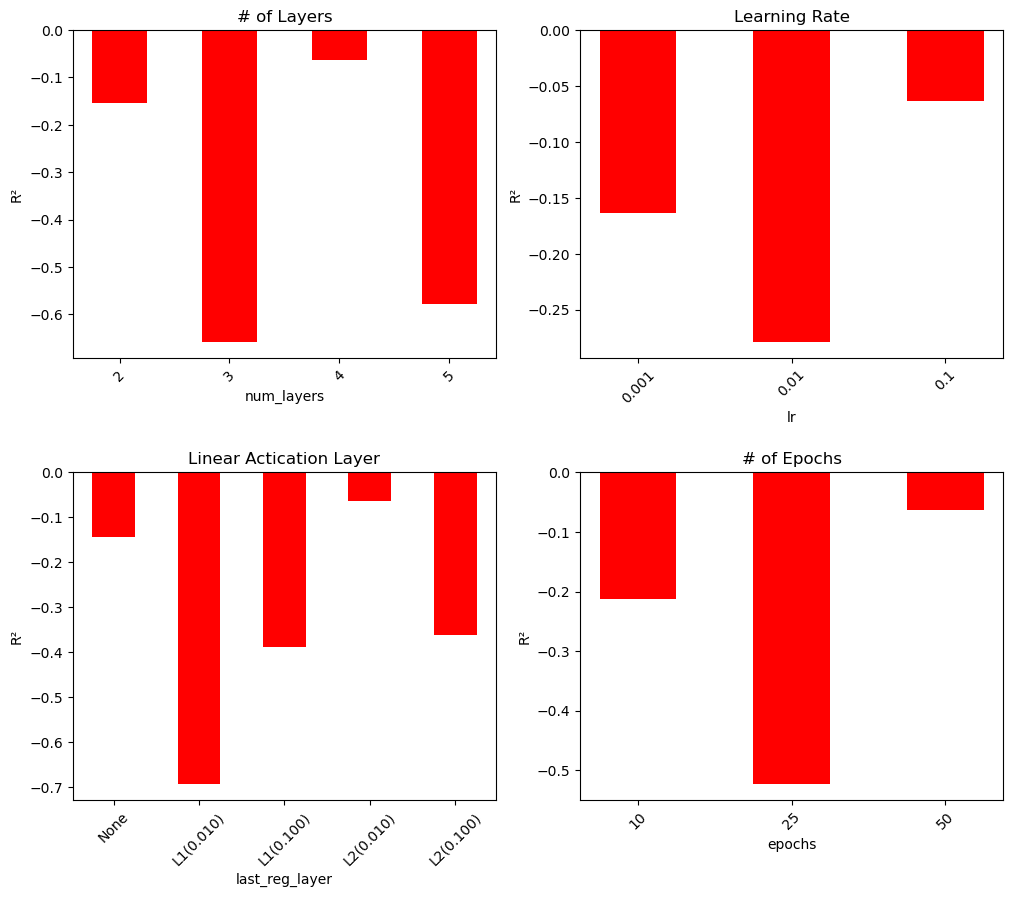

In [146]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
bar_width = 0.5
names = ['# of Layers', 'Learning Rate', 'Linear Actication Layer', '# of Epochs']

for idx, sweep in enumerate(sweeps):
    x_vals = sweep[param_names[idx]]
    y_vals = sweep['r2_valid']
    positions = np.arange(len(x_vals))
    
    axes[idx].bar(positions, y_vals, width=bar_width, color='red')
    axes[idx].set_xticks(positions)
    axes[idx].set_xticklabels(x_vals, rotation=45)
    axes[idx].set_title(names[idx])
    axes[idx].set_ylabel("R²")
    axes[idx].set_xlabel(param_names[idx])

plt.subplots_adjust(hspace=0.35)



---

<h1><center>Random Forest

---

In [147]:
results_df.head()

,num_layers,lr,last_reg_layer,epochs,r2_train,r2_valid,model
0,2,0.001,None,10,-5.535480,-6.433413,"<Sequential name=sequential_616, built=True>"
1,2,0.001,None,25,-4.895329,-5.654064,"<Sequential name=sequential_617, built=True>"
2,2,0.001,None,50,-3.338553,-3.762615,"<Sequential name=sequential_618, built=True>"
3,2,0.001,L1(0.010),10,-5.538309,-6.437144,"<Sequential name=sequential_619, built=True>"
4,2,0.001,L1(0.010),25,-4.896817,-5.654358,"<Sequential name=sequential_620, built=True>"


---

<h1><center>Extra Workspace

---